In [1]:
import torch # this first torch import is CRUCIAL for finding the libtorch files!
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt

from sph_lib.deposition import (compute_hsm, compute_hsm_tensor, project_hsm_tensor_to_2d, p2g)

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('~/Desktop/sph_lib/mnras')

In [2]:
ds = pn.load('../../data/snapshot_176_128.hdf5')

/opt/anaconda3/envs/my_env/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:635: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)


In [3]:
# simulation information
periodic = True
boxsize  = 15000
extent   = np.array([0, boxsize])

# grid information
NN       = 8
gridnum  = 50

In [4]:
# needed fields
pos      = ds.dm['pos']
masses   = ds.dm['mass']

#--------
if True:
    mask = (pos[:, 2] < 500) & (pos[:, 0] < 2000) & (pos[:, 1] < 2000)

    pos = pos[mask]
    masses = masses[mask]
    extent = np.array([0, 2000])
#--------

# IMPORTANT: hsm (tensor) needs to be computed from the 3d distribution (unless the simulation is 2d)!!
hsm = compute_hsm(pos, NN, boxsize)[0]
hmat, eλ, ev = compute_hsm_tensor(pos, masses, NN, boxsize)

# stack all quantities to deposit
quantities = np.stack([masses], axis=-1); print(quantities.shape)

# do we need to average the deposited quantities or not?
averaged   = [False]

(1237, 1)


/opt/anaconda3/envs/my_env/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:469: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


In [5]:
kwargs = {'positions': pos, 
          'quantities': quantities, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1
          }

In [6]:
def compute_mass_error(grid_mass):
    true_mass = masses.sum()
    ratio = (grid_mass.sum() / true_mass - 1.0) * 1e2
    return ratio

In [7]:
#print(quantities[:, 0].sum())
#fields_ngp = p2g(**kwargs, method='ngp')
#print(f'NGP:', compute_mass_error(fields_ngp[..., 0]))
#
#fields_cic = p2g(**kwargs, method='cic')
#print(f'CIC:', compute_mass_error(fields_cic[..., 0]))
#
#fields_tsc = p2g(**kwargs, method='tsc')
#print(f'TSC:', compute_mass_error(fields_tsc[..., 0]))

In [8]:
#fields_ngp = p2g(**kwargs, method='ngp', accelerator='cpp')
#print(f'NGP:', compute_mass_error(fields_ngp[..., 0]))
#
#fields_cic = p2g(**kwargs, method='cic', accelerator='cpp')
#print(f'CIC:', compute_mass_error(fields_cic[..., 0]))
#
#fields_tsc = p2g(**kwargs, method='tsc', accelerator='cpp')
#print(f'TSC:', compute_mass_error(fields_tsc[..., 0]))

In [9]:
#fields_cic_ada_cpp = p2g(**kwargs, method='cic_adaptive', accelerator='cpp', num_nn=NN)
#print(f'CIC adaptive:', compute_mass_error(fields_cic_ada_cpp[..., 0]))
#
#fields_tsc_ada_cpp = p2g(**kwargs, method='tsc_adaptive', accelerator='cpp', num_nn=NN)
#print(f'TSC adaptive:', compute_mass_error(fields_tsc_ada_cpp[..., 0]))

In [10]:
print(pos.shape)
print(hsm.shape)
print(hmat.shape)

(1237, 3)
(1237,)
(1237, 3, 3)


In [11]:
hmat_2d, eλ_2d, ev_2d = project_hsm_tensor_to_2d(hmat, plane=(0, 1))
print(hmat_2d.shape)

(1237, 2, 2)


In [12]:
mask = (pos[:, 2] < 200) & (pos[:, 0] < 10000) & (pos[:, 1] < 10000)

pos_masked = pos[mask][:, :2]
quantities_masked = quantities[mask]
hsm_masked = hsm[mask]
hmat_masked = hmat[mask]
hmat_2d_masked = hmat_2d[mask]
eλ_2d_masked = eλ_2d[mask]
ev_2d_masked = ev_2d[mask]

In [13]:
eλ_2d_masked.shape

(459, 2)

3.1004045310958785


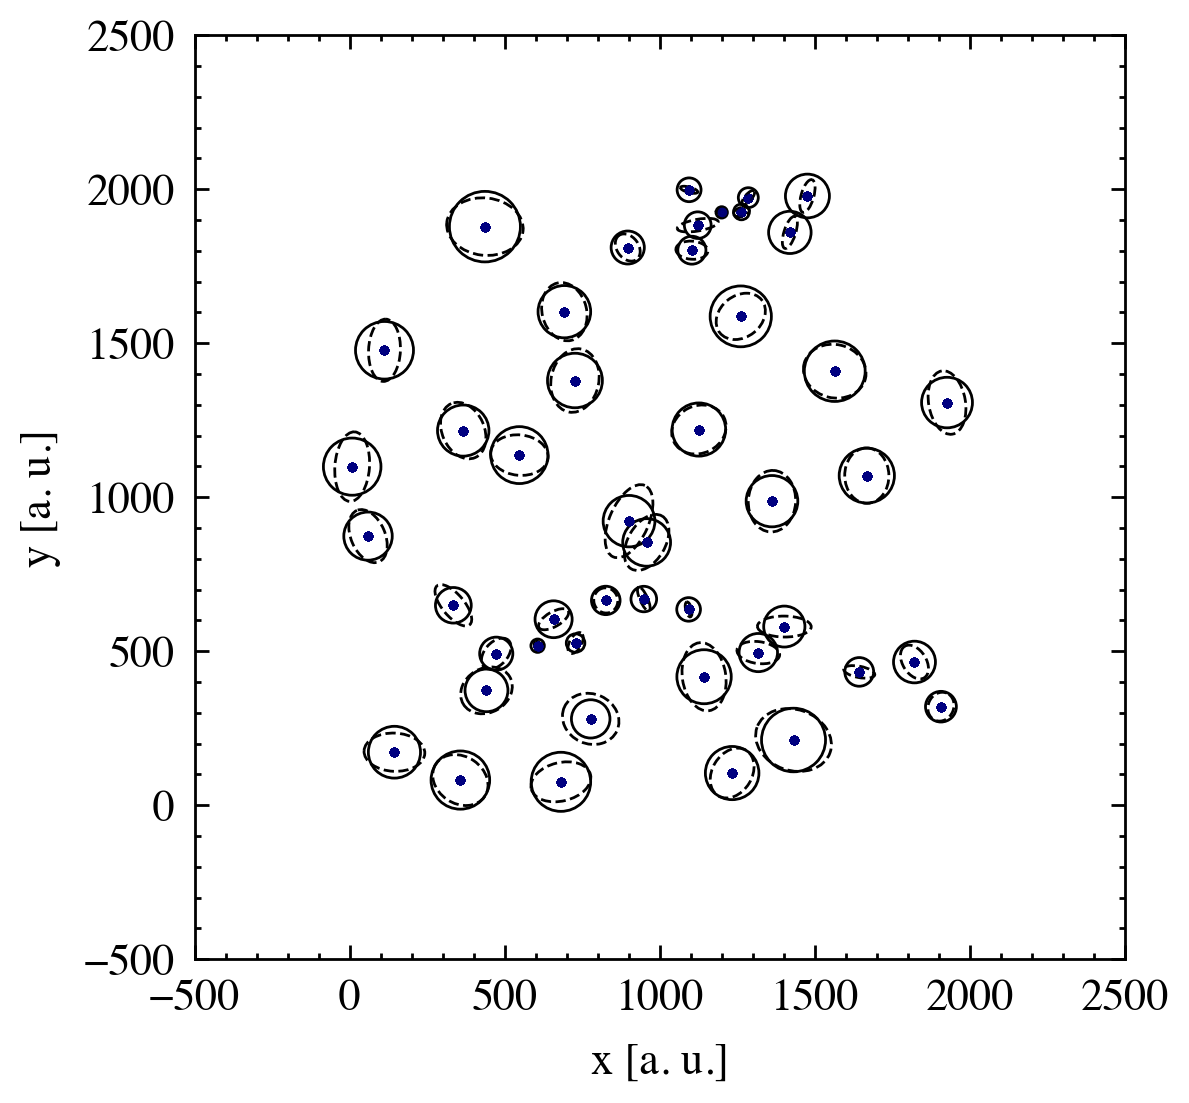

In [14]:
from matplotlib.patches import Circle, Ellipse

N = 10
fig, ax = plt.subplots(figsize=(3, 3))

def draw_circle(ax, center, radius):
    circle = Circle(center, radius, 
                    fill=False, edgecolor='k', lw=0.5, alpha=1.0)
    ax.add_patch(circle)

def draw_ellipse(ax, center, width, height, angle):
    ellipse = Ellipse(center, width, height, angle=angle, 
                      fill=False, edgecolor='k', lw=0.5, alpha=1.0, ls='--')
    ax.add_patch(ellipse)

print(np.max(eλ_2d_masked[::N] / hsm_masked[::N, np.newaxis]))

for p, h, w, v in zip(pos_masked[::N], 
                      hsm_masked[::N], 
                      eλ_2d_masked[::N], 
                      ev_2d_masked[::N]):

    # Calculate width, height, and angle of the ellipse
    width, height = w
    angle = np.degrees(np.arctan2(*v[:, 0][::-1]))

    if width / h > 10 or height / h > 10:
        m = 'd'
    else:
        m = 'o'
    ax.scatter(pos_masked[::N, 0], 
               pos_masked[::N, 1], 
               s=0.5, alpha=0.5, marker=m, color='navy')

    # Draw the smoothing circle and ellipse
    center = (p[0], p[1])
    draw_circle(ax, center, h)
    draw_ellipse(ax, center, width, height, angle)

plt.xlim(-500, 2000+500)
plt.ylim(-500, 2000+500)
plt.xlabel('x [a. u.]')
plt.ylabel('y [a. u.]')
plt.savefig('../plots/mass_conservation_test')
plt.show()

F = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='gaussian')
print(f'SPH isotropic Gaussian:', compute_mass_error(F[..., 0]))
F = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='super_gaussian')
print(f'SPH isotropic Super Gaussian:', compute_mass_error(F[..., 0]))
F = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='cubic')
print(f'SPH isotropic Cubic:', compute_mass_error(F[..., 0]))
F = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='quintic')
print(f'SPH isotropic Quintic:', compute_mass_error(F[..., 0]))
F = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c2')
print(f'SPH isotropic Wendland C2:', compute_mass_error(F[..., 0]))
F = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c4')
print(f'SPH isotropic Wendland C4:', compute_mass_error(F[..., 0]))
F = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c6')
print(f'SPH isotropic Wendland C6:', compute_mass_error(F[..., 0]))

In [15]:
#TODO: this is not working yet, need to fix the adaptive deposition in cpp
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='gaussian')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='super_gaussian')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='cubic')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='quintic')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c2')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c4')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c6')
#print(f'SPH anisotropic Gaussian:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Super Gaussian:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Cubic:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Quintic:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Wendland C2:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Wendland C4:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Wendland C6:', compute_mass_error(F[..., 0]), '\n')

In [16]:
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='gaussian', integration='trapezoidal')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='super_gaussian', integration='trapezoidal')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='cubic', integration='trapezoidal')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='quintic', integration='trapezoidal')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c2', integration='trapezoidal')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c4', integration='trapezoidal')
F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c6', integration='trapezoidal')
#print(f'SPH anisotropic Gaussian:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Super Gaussian:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Cubic:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Quintic:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Wendland C2:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Wendland C4:', compute_mass_error(F[..., 0]), '\n')
#print(f'SPH anisotropic Wendland C6:', compute_mass_error(F[..., 0]), '\n')

In [17]:
#F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='gaussian', integration='simpson')
#F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='super_gaussian', integration='simpson')
#F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='cubic', integration='simpson')
#F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='quintic', integration='simpson')
#F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c2', integration='simpson')
#F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c4', integration='simpson')
#F = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c6', integration='simpson')

In [18]:
kwargs = {'positions': pos_masked, 
          'quantities': quantities_masked, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1
          }

In [19]:
F, W = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', 
           hmat_eigvecs=ev_2d_masked, hmat_eigvals=eλ_2d_masked, kernel_name='gaussian', return_weights=True)

torch.Size([50, 50])


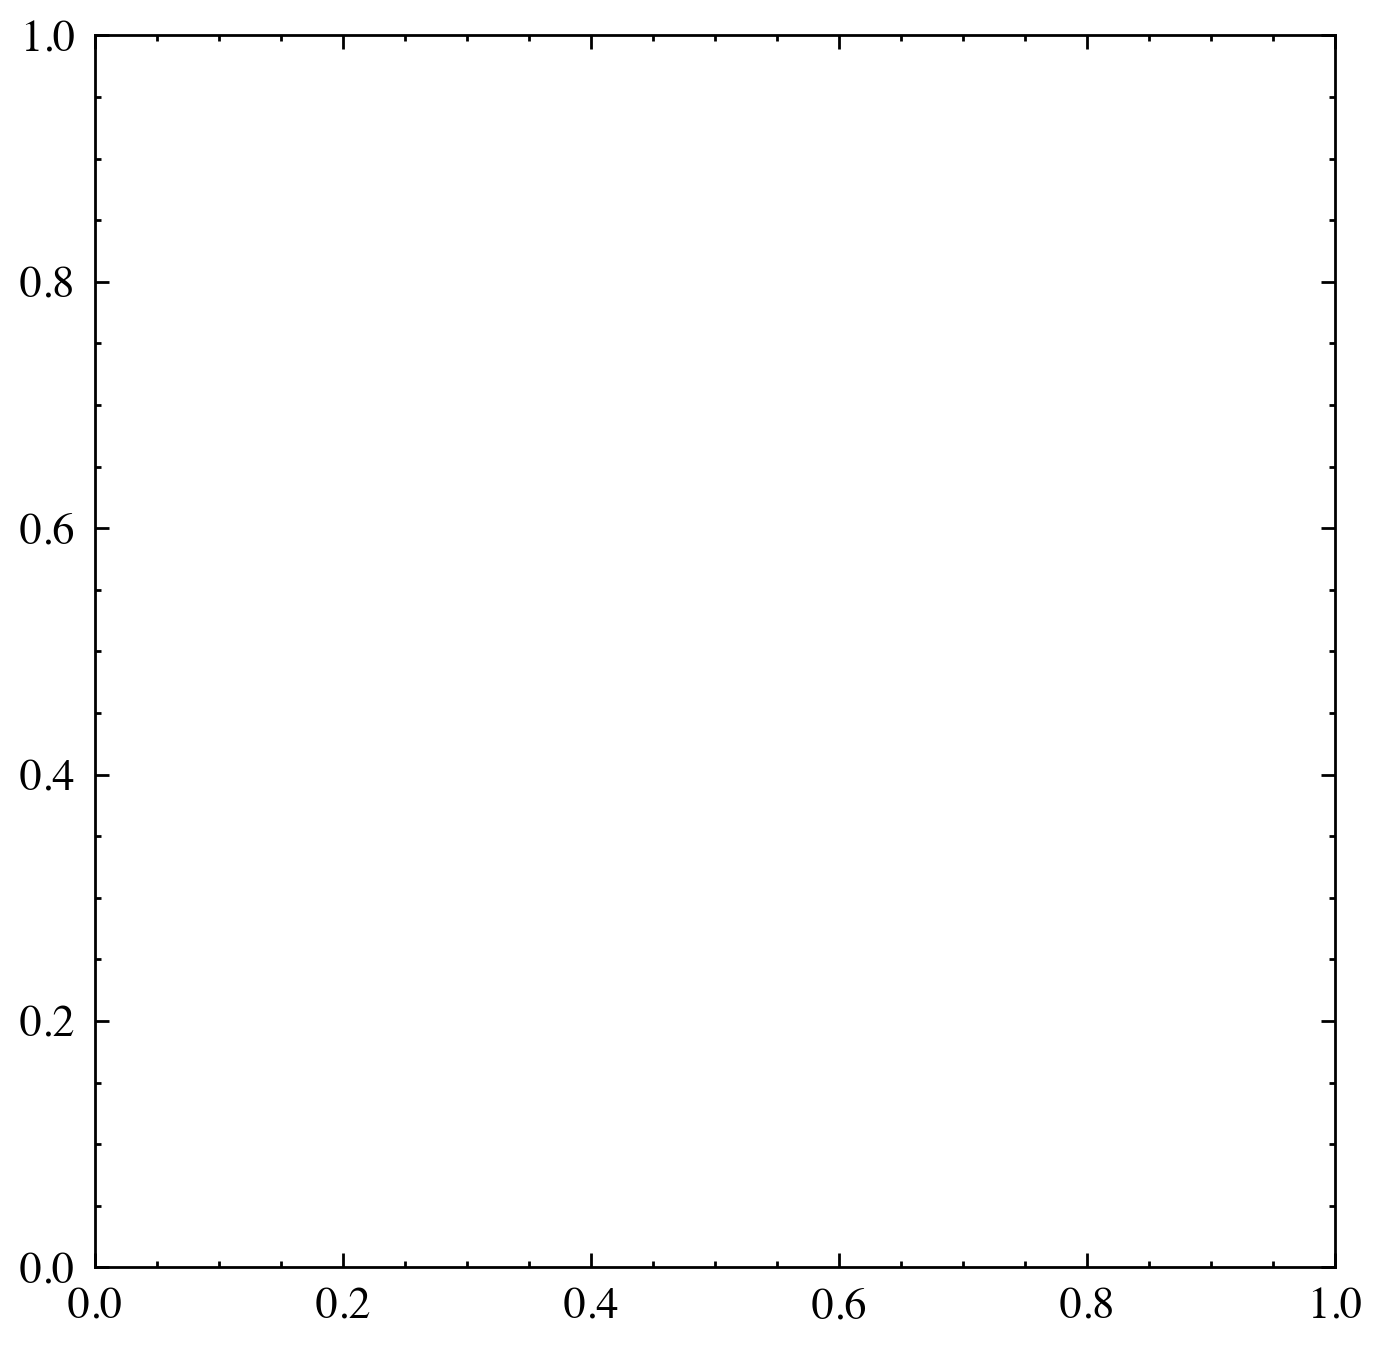

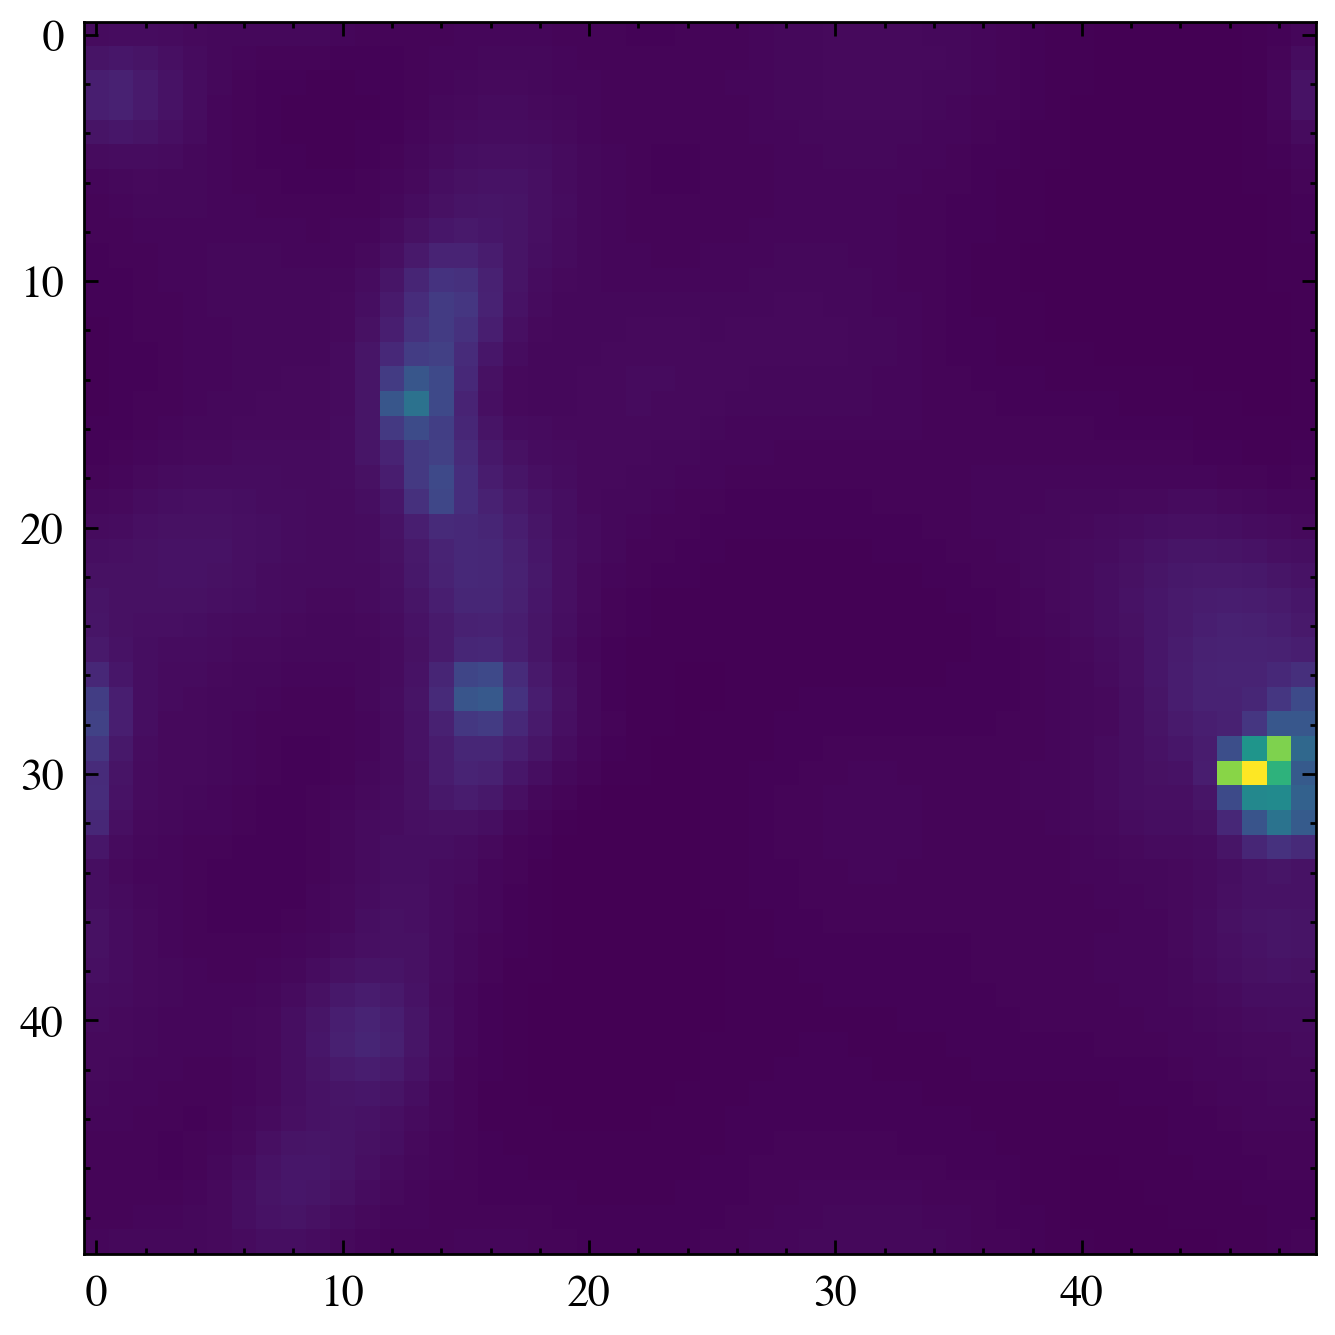

In [21]:
print(W.shape)
plt.figure(figsize=(4, 4))
plt.imshow(W.cpu().numpy())
plt.show()

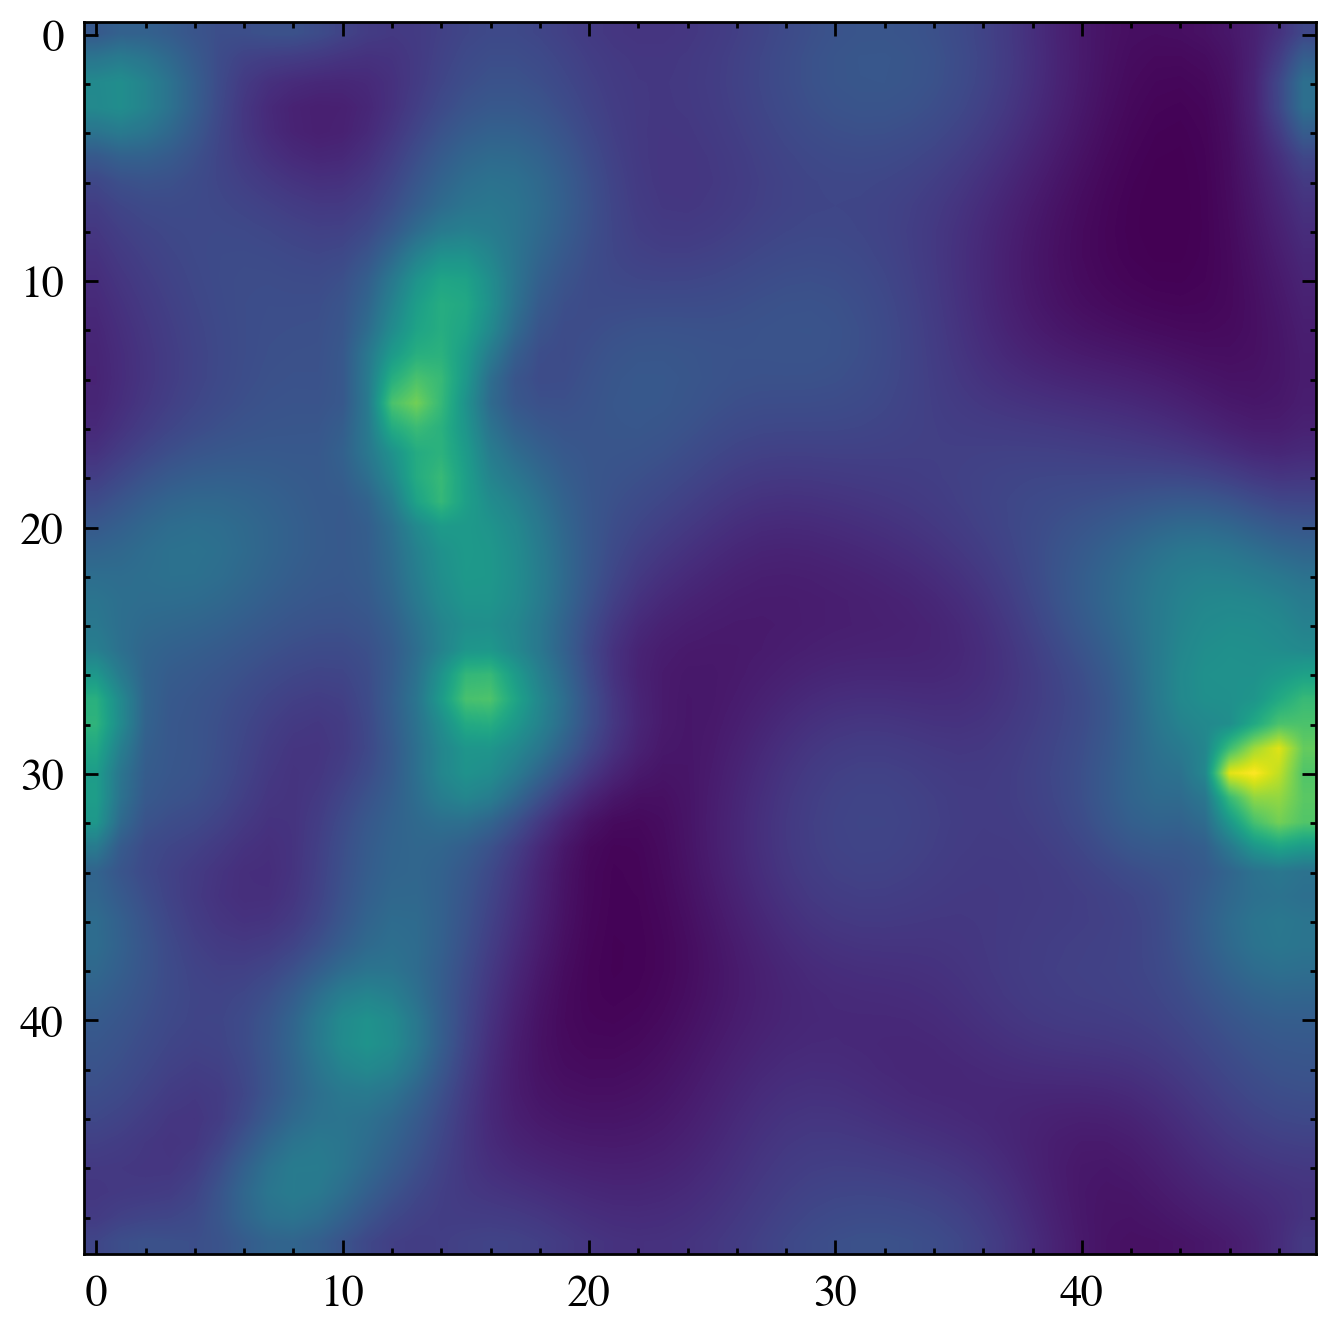

In [24]:
plt.figure(figsize=(4, 4))
plt.imshow(np.log10(F[:, :, 0].cpu().numpy()), interpolation='bilinear')
plt.show()

3.1658684058790607


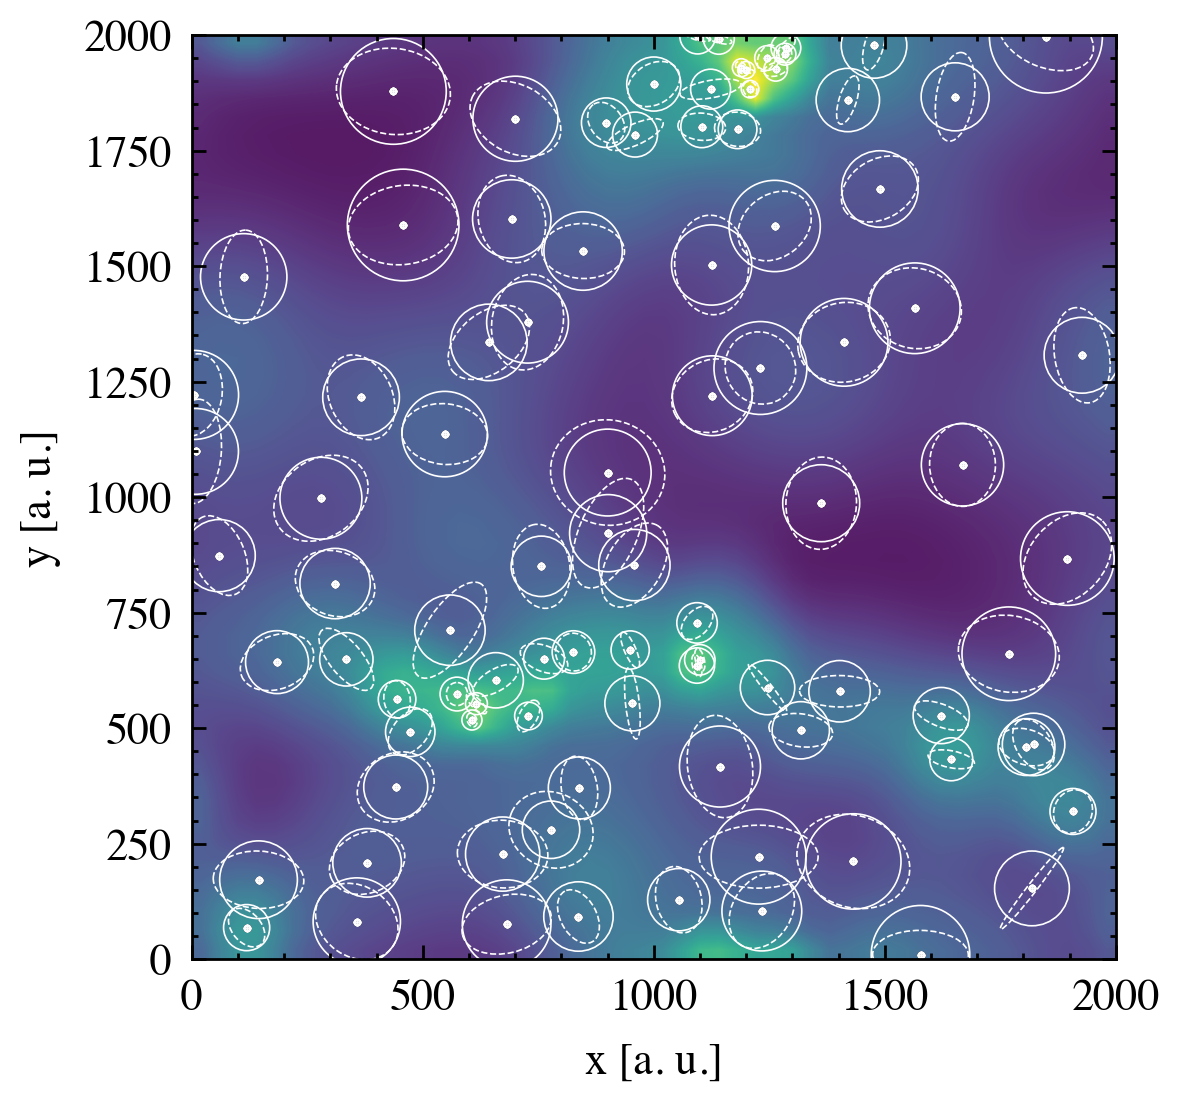

In [51]:
from matplotlib.patches import Circle, Ellipse

N = 5
fig, ax = plt.subplots(figsize=(3, 3))

def draw_circle(ax, center, radius):
    circle = Circle(center, radius, 
                    fill=False, edgecolor='w', lw=0.3, alpha=1.0)
    ax.add_patch(circle)

def draw_ellipse(ax, center, width, height, angle):
    ellipse = Ellipse(center, width, height, angle=angle, 
                      fill=False, edgecolor='w', lw=0.3, alpha=1.0, ls='--')
    ax.add_patch(ellipse)

print(np.max(eλ_2d_masked[::N] / hsm_masked[::N, np.newaxis]))

ax.imshow(np.rot90(np.log10(F[:, :, 0].cpu().numpy())), interpolation='bilinear',
          extent=[extent[0], extent[1], extent[0], extent[1]],
          alpha=0.9)

for p, h, w, v in zip(pos_masked[::N], 
                      hsm_masked[::N], 
                      eλ_2d_masked[::N], 
                      ev_2d_masked[::N]):

    # Calculate width, height, and angle of the ellipse
    width, height = w
    angle = np.degrees(np.arctan2(*v[:, 0][::-1]))

    #if width / h > 10 or height / h > 10:
    #    m = 'd'
    #else:
    #m = '.'
    ax.scatter(pos_masked[::N, 0], 
               pos_masked[::N, 1], 
               s=0.1, 
               alpha=0.5, 
               marker='o',
               color='w')

    # Draw the smoothing circle and ellipse
    center = (p[0], p[1])
    draw_circle(ax, center, h)
    draw_ellipse(ax, center, width, height, angle)

#plt.xlim(-500, 2000+500)
#plt.ylim(-500, 2000+500)
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.xlabel('x [a. u.]')
plt.ylabel('y [a. u.]')
plt.savefig('../plots/anisotropy_test')
plt.show()